In [59]:
import pandas as pd
import requests
import bs4
from bs4 import BeautifulSoup  
import json
import csv
import numpy as np
import matplotlib.pyplot as plt      
import math
import matplotlib.pyplot as plt
import geopandas
from shapely.geometry import Point

In [60]:
df = pd.read_csv("Real_Estate_TLV_Full_DATA.csv",index_col=0)
yad2_df = pd.read_csv("Real_Estate_TLV_YAD2_Numeric.csv",index_col=0)

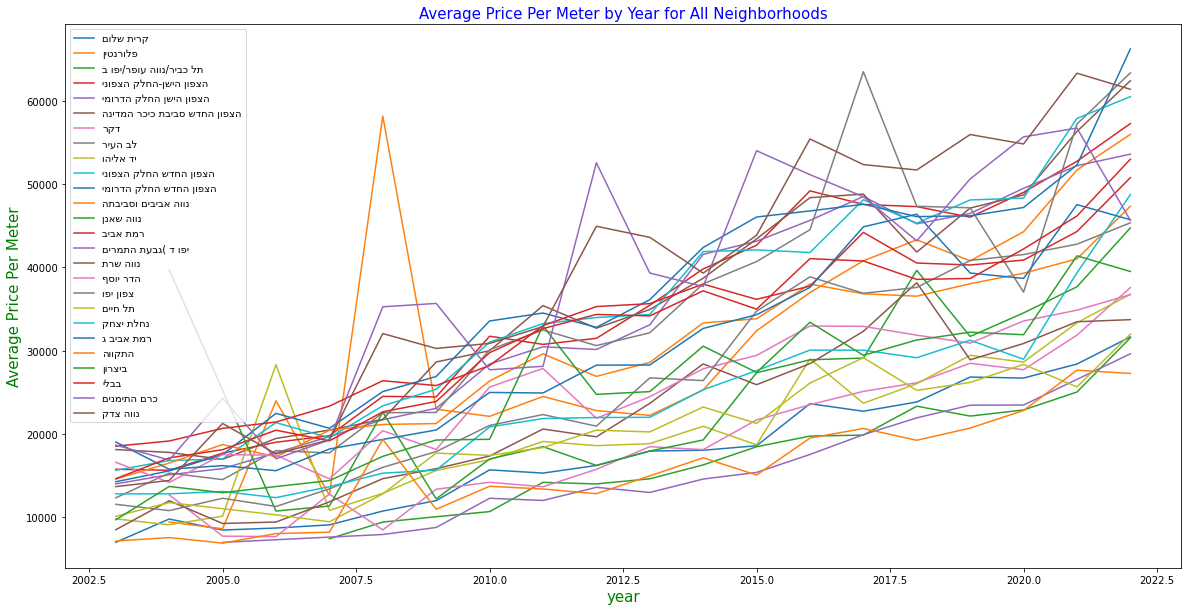

In [61]:
def remove_small_amount_deals_n(df):
    to_remove = []
    neighborhoods = df['NEIGHBORHOOD'].value_counts()
    for val in range(len(neighborhoods.values)):
        if neighborhoods[val] < 500:
            to_remove.append(neighborhoods.index[val])

    return df.drop(df[df['NEIGHBORHOOD'].isin(to_remove)].index).reset_index(drop=True)

def line_plot_neighborhoods(df):    
    df = remove_small_amount_deals_n(df)
    neighborhoods = df['NEIGHBORHOOD'].unique()
    neighborhoods_change_price = {}
    for neighborhood in neighborhoods:
    #get data for the neighborhood
        df_neighborhood = df[df['NEIGHBORHOOD'] == neighborhood]
        avg_price_meter_data = df_neighborhood.groupby(['DATE']).mean()['PRICE_PER_METER']
        neighborhoods_change_price[neighborhood] = avg_price_meter_data
        
    plt.figure(figsize=(20,10))    
    plt.title('Average Price Per Meter by Year for All Neighborhoods', color = 'b', fontsize = 15)
    plt.xlabel('year', color = 'g', fontsize = 15)
    plt.ylabel('Average Price Per Meter', color = 'g', fontsize = 15)
    for key, values in neighborhoods_change_price.items():
        plt.plot(values.index, values, label=key[::-1])
        
    plt.legend()
    plt.show()


line_plot_neighborhoods(df)


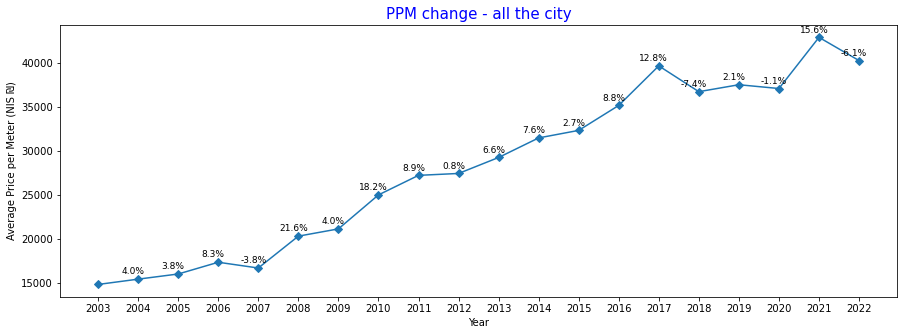

In [62]:
def plot_price_change(df):
    df_grouped = df.groupby(['DATE']).mean()
    plt.figure(figsize=(15,5))  
    plt.title('PPM change - all the city', color = 'b', fontsize = 15)

    plt.plot(df_grouped.index, df_grouped['PRICE_PER_METER'], '-D')
    plt.xlabel('Year')
    plt.ylabel('Average Price per Meter (NIS ₪)')
    plt.xticks(df_grouped.index)
    
    # Calculate the percentage change
    price_change = (df_grouped['PRICE_PER_METER'].diff() / df_grouped['PRICE_PER_METER'].shift(1)) * 100
    price_change.dropna(inplace=True)
    # Add the change as text annotations
    for i, change in enumerate(price_change):
        x = price_change.index[i]
        y = df_grouped.loc[x, 'PRICE_PER_METER']
        plt.annotate("{:.1f}%".format(change), (x, y), textcoords="offset points", xytext=(-5,5), ha='center', fontsize=9)
    
    
    plt.show()
    
plot_price_change(df)

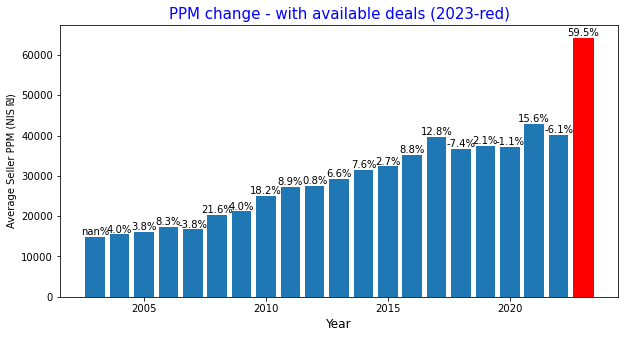

<Figure size 1080x360 with 0 Axes>

In [63]:

def plot_avg_seller_ppm(df1, df2):
    # Calculate the average seller PPM(price per meter) for each year in df1 (deal hisory)
    avg_seller_ppm = df1.groupby('DATE')['PRICE_PER_METER'].mean()
    
    df2['PRICE_PER_METER'] = (df2['price']/df2['buildingMR']).round(1)
    yad2_ppm = df2['PRICE_PER_METER'].mean()

    combined_df = pd.concat([avg_seller_ppm, pd.Series([yad2_ppm], index=[2023])])
    
    # Calculate the change in average seller PPM between each year 
    price_change = (combined_df.diff() / combined_df.shift(1)) * 100

    
    fig, ax = plt.subplots()
    plt.title('PPM change - with available deals (2023-red)', color = 'b', fontsize = 15)

    bars = ax.bar(combined_df.index, combined_df.values)
    
    ax.set_xlabel('Year', fontsize = 12)
    ax.set_ylabel('Average Seller PPM (NIS ₪)')
    plt.figure(figsize=(15,5)) 

    # Add labels above each bar showing the change between each year 
    for i, patch in enumerate(bars):
        if i == len(bars) - 1:
            # Set the color of the last bar to red
            patch.set_color('red')
        ax.text(patch.get_x() + patch.get_width() / 2, patch.get_height() + 0.5,
                '{:.1f}%'.format(price_change.iloc[i]), ha='center', va='bottom')
    
    
    
    fig.set_size_inches(10, 5)
    plt.show()
    

plot_avg_seller_ppm(df,yad2_df)


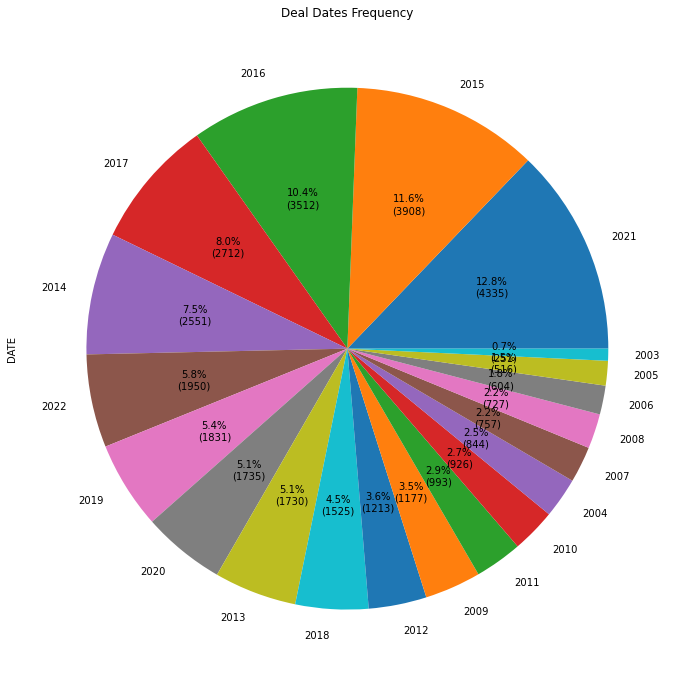

In [64]:
def func(pct, allvals):
    absolute = int(np.round(pct/100.*np.sum(allvals)))
    return "{:.1f}%\n({:d})".format(pct, absolute)



def dealdate_plot(df):
    years_counts=df['DATE'].value_counts()
    years_count_sort = years_counts # .sort_values(ascending=True)
    years_count_sort.plot.pie(figsize=(12, 12),autopct=lambda pct: func(pct, years_count_sort) ,labels=years_counts.index,)
    plt.title('Deal Dates Frequency')
    plt.show()
    
dealdate_plot(df)

In [65]:
def LinearRegression_TLV(df):
    avg = df.groupby(['DATE']).mean()['PRICE_PER_METER']
    x = np.array(avg.index).reshape(-1,1)
    y = np.array(avg.values).reshape(-1,1)
    linreg = LinearRegression().fit(x,y)
    plt.figure(figsize=(15,5))

    plt.scatter(x,y , label = 'Actual Price')
    ax = plt.gca()

    plt.title('Least Squares', color = 'b', fontsize = 15)
    ax.set_xlabel('Year', color = 'g', fontsize = 15)
    ax.set_ylabel('Price Per Meter', color = 'g', fontsize = 15)
    plt.plot(x,linreg.intercept_+linreg.coef_*x, color='r', label = 'Predicted Price')
    plt.legend()
    plt.show()
# LinearRegression_TLV(df)


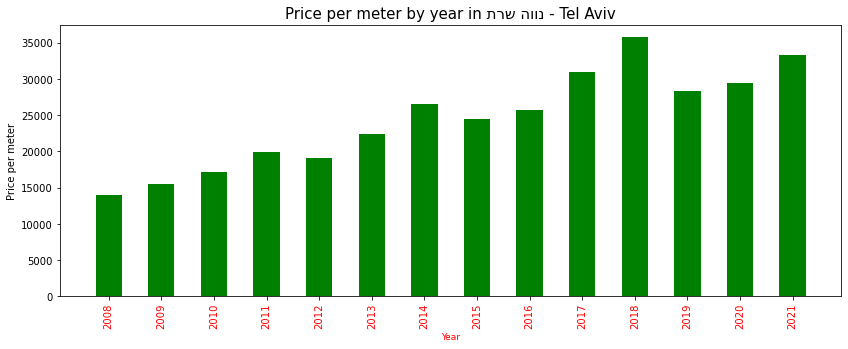

In [66]:
def Price_Increases_Neighborhood(df, neighborhood):
  # Isolate the relevant neighborhood
  # Calculate the price per meter for each year (2000- until today)
    years = range(2000, 2022)
    price_per_meter_by_year = {}
    for year in years:
        year_data = df[(df["NEIGHBORHOOD"] == neighborhood) & (df['DATE'] == year)]
        if year_data.shape[0] > 10:
            average_price_per_meter = year_data['DEALAMOUNT'].sum() / year_data['ASSETMETER'].sum()
            price_per_meter_by_year[year] = round(average_price_per_meter)
            
    plt.figure(figsize=(14,5))
    bars = tuple(price_per_meter_by_year.keys())
    x_pos = np.arange(len(bars))
    plt.bar(x_pos, price_per_meter_by_year.values(),color = 'g', width = 0.5)
    plt.xticks(x_pos, bars, rotation=90 ,color = 'r')        
    plt.title(f"Price per meter by year in {neighborhood[::-1]} - Tel Aviv" , fontsize= 15)
    plt.xlabel("Year" , color = 'r', fontsize = 9)
    plt.ylabel("Price per meter")
    plt.show()

n = 'נווה שרת'
Price_Increases_Neighborhood(df,n)

In [67]:
def predict_price_in_2030(df, neighborhood, size):
  # Calculate the price per meter for each year (2000- until today)
    years = range(2000, 2020)
    price_per_meter_by_year = {}
    for year in years:
        year_data = df[(df["NEIGHBORHOOD"] == neighborhood) & (df['DATE'] == year)]
        if year_data.shape[0] > 10:
            average_price_per_meter = year_data['DEALAMOUNT'].sum() / year_data['ASSETMETER'].sum()
            price_per_meter_by_year[year] = round(average_price_per_meter)
            
    return price_per_meter_by_year
    
t = predict_price_in_2030(df,n,45)


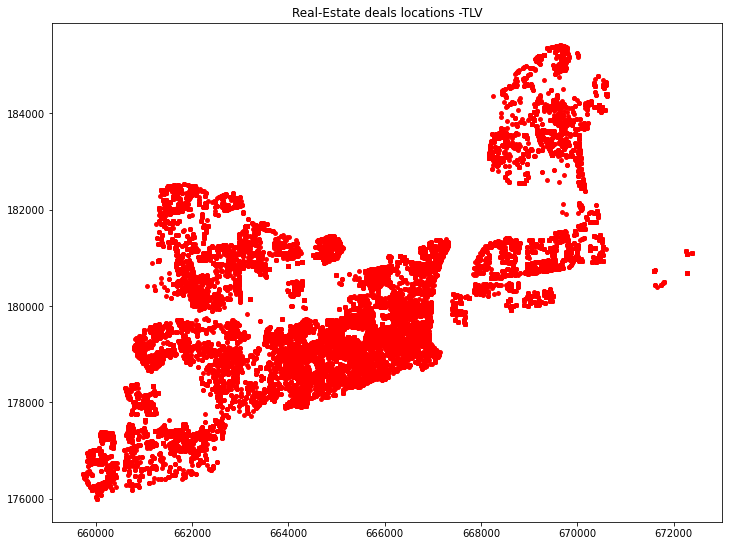

In [68]:
def show_map(df):

    #create a list of points
    points_list = [Point(xy) for xy in zip(df.long, df.lat)]

    #create a geopandas df
    gdf = geopandas.GeoDataFrame(df, geometry=points_list)
    
    #plot the map
    ax = gdf.plot(figsize=(12, 12),marker='o', color='red', markersize=15)
    ax.set_title('Real-Estate deals locations -TLV')
    
    plt.show()
    
show_map(df)
